# pycaret을 이용한 가스공급량 예측
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'
* 특성
    * 'month', '시간'으로 기온 예측
    * 기온, 기압, 습도 순서로 예측
    * 각 특성 예측 마다 앞에서 예측한 특성 활용
    * 공급량 예측(6개) : 'month', '시간', '구분', '기온', '기압', '습도'
* 공급량 log적용
* 2개 모델('lightgbm', 'catboost') 예측 평균
* 튜닝 제외

In [143]:
# 제출 파일명 : sub20_pycaret08.csv
# 제출 점수 : 0.1069848285(2021-12-01 15:27:22)

## 데이터 가져오기
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'

In [144]:
from pycaret.regression import *

In [145]:
import time
import datetime
import pandas as pd

### 2013-2018년 가스공급량과 기온 자료

In [146]:
total = pd.read_csv('../2013-2018년_가스공급량_기온_습도_기압01.csv')
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


### 2019년 데이터

In [147]:
test2019 = pd.read_csv('../data/test.csv')
test2019.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [148]:
test2019[['연월일', '시간', '구분']] = test2019['일자|시간|구분'].str.split(' ').tolist()
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A


In [149]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(test2019['구분'].unique()):
    d_map[d] = i
test2019['구분'] = test2019['구분'].map(d_map)
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,0
1,2019-01-01 02 A,2019-01-01,02,0
2,2019-01-01 03 A,2019-01-01,03,0
3,2019-01-01 04 A,2019-01-01,04,0
4,2019-01-01 05 A,2019-01-01,05,0


In [150]:
# 연월일 열은 object형이므로 년, 월, 일로 나눈다.
test2019['연월일'] = pd.to_datetime(test2019['연월일'])
test2019['year'] = test2019['연월일'].dt.year
test2019['month'] = test2019['연월일'].dt.month
test2019['day'] = test2019['연월일'].dt.day
test2019['weekday'] = test2019['연월일'].dt.weekday
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


### 상관계수 확인

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

import platform
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

<AxesSubplot:>

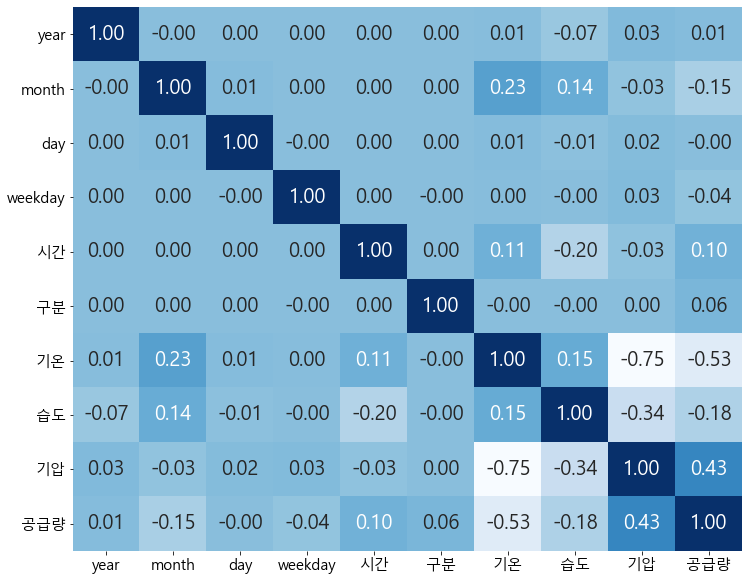

In [152]:
plt.figure(figsize=(12,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(total[['year','month', 'day', 'weekday', '시간', '구분', '기온','습도','기압','공급량']].corr(), cmap='Blues', annot=True, fmt='.2f', cbar=False, annot_kws={"size": 20})

(array([ 1631., 12285., 32193., 47222., 53382., 56679., 58002., 46487.,
        38262., 21945.]),
 array([  7. ,  16.3,  25.6,  34.9,  44.2,  53.5,  62.8,  72.1,  81.4,
         90.7, 100. ]),
 <BarContainer object of 10 artists>)

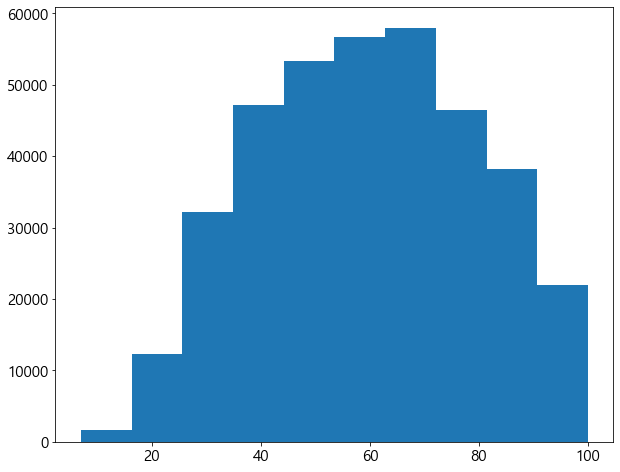

In [153]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='습도', data=total)

(array([  420.,  1414.,  9597., 43568., 77329., 70378., 79037., 60480.,
        23170.,  2695.]),
 array([ 976.5 ,  981.68,  986.86,  992.04,  997.22, 1002.4 , 1007.58,
        1012.76, 1017.94, 1023.12, 1028.3 ]),
 <BarContainer object of 10 artists>)

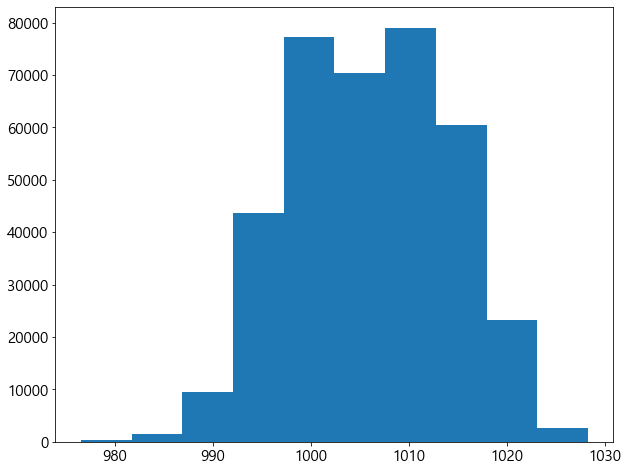

In [154]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기압', data=total)

(array([ 1708., 12180., 36729., 52906., 48832., 49889., 64701., 73080.,
        26040.,  2023.]),
 array([-18.  , -12.26,  -6.52,  -0.78,   4.96,  10.7 ,  16.44,  22.18,
         27.92,  33.66,  39.4 ]),
 <BarContainer object of 10 artists>)

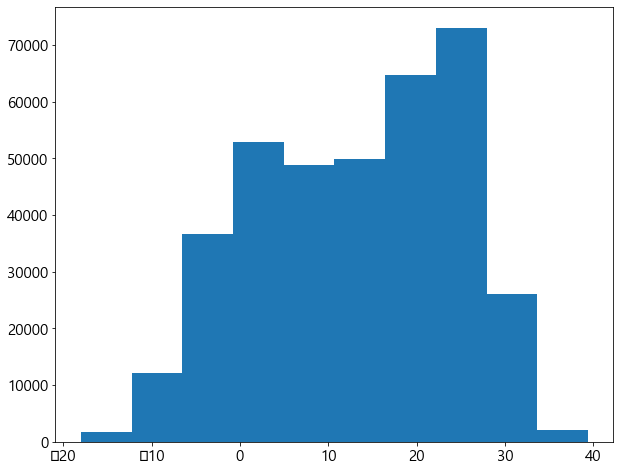

In [155]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기온', data=total)

(array([2.56069e+05, 7.60110e+04, 2.76280e+04, 7.43600e+03, 8.86000e+02,
        5.30000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.37800000e+00, 1.16060190e+03, 2.31982580e+03, 3.47904970e+03,
        4.63827360e+03, 5.79749750e+03, 6.95672140e+03, 8.11594530e+03,
        9.27516920e+03, 1.04343931e+04, 1.15936170e+04]),
 <BarContainer object of 10 artists>)

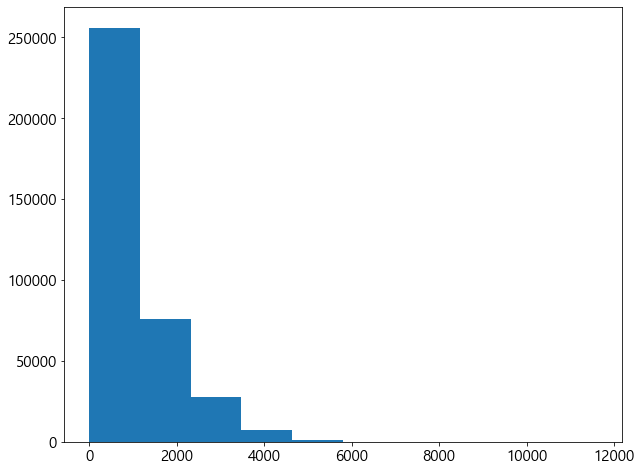

In [156]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량', data=total)

<Figure size 864x576 with 0 Axes>

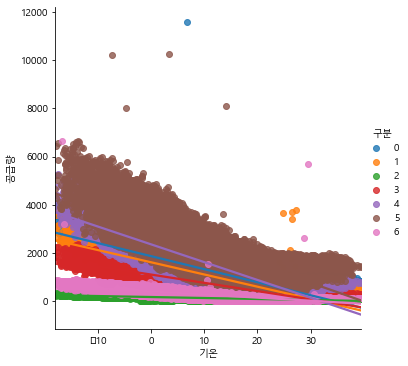

In [157]:
plt.figure(figsize=(12,8))
sns.lmplot(x='기온', y='공급량', hue='구분', data=total)

## 2019년 기온 훈련하기

In [158]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [159]:
# 학습 특성 : 'month', '시간'
# 타겟 특성 : '기온'

exp = setup(total, target='기온',
 ignore_features=['공급량', 'year', 'day', 'weekday', '구분', '습도', '기압'],
 silent=True, fold=7, fold_shuffle=True, verbose=False)

In [160]:
# 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [161]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.0090,15.0967,3.8855,0.8821,0.5171,0.7940
1,2.9981,15.0064,3.8738,0.8810,0.5082,0.8044
2,3.0059,14.9800,3.8704,0.8816,0.5152,0.8079
3,3.0374,15.2823,3.9093,0.8791,0.5203,0.8115
4,2.9867,14.8229,3.8500,0.8833,0.5123,0.7863
5,3.0215,15.2234,3.9017,0.8809,0.5194,0.8006
6,3.0117,15.0656,3.8814,0.8812,0.5177,0.8313
Mean,3.0100,15.0682,3.8817,0.8813,0.5157,0.8051
SD,0.0151,0.1427,0.0184,0.0012,0.0039,0.0133


0:00:17


In [162]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.0090,15.0974,3.8855,0.8821,0.5171,0.7941
1,2.9983,15.0084,3.8741,0.8810,0.5089,0.8045
2,3.0060,14.9803,3.8704,0.8816,0.5150,0.8081
3,3.0376,15.2843,3.9095,0.8791,0.5202,0.8115
4,2.9865,14.8221,3.8499,0.8833,0.5128,0.7864
5,3.0213,15.2233,3.9017,0.8809,0.5194,0.8006
6,3.0116,15.0653,3.8814,0.8812,0.5178,0.8315
Mean,3.0100,15.0687,3.8818,0.8813,0.5159,0.8052
SD,0.0151,0.1432,0.0184,0.0012,0.0037,0.0133


0:02:56


In [163]:
# lgbm 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_lgbm = finalize_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:08


In [164]:
# cat 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:03:31


### 2019년 기온 예측

In [165]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [166]:
# lgbm 기온 예측
start = time.time()

df = test2019[['month', '시간']]
temp2019_pred_lgbm = predict_model(temp_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [167]:
# cat 기온 예측
start = time.time()

df = test2019[['month', '시간']]
temp2019_pred_cat = predict_model(temp_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [168]:
temp2019_pred_lgbm.head()

,month,시간,Label
0,1,01,-3.587560
1,1,02,-3.860868
2,1,03,-4.114262
3,1,04,-4.351189
4,1,05,-4.569531


In [169]:
temp2019_pred_cat.head()

,month,시간,Label
0,1,01,-3.577430
1,1,02,-3.860079
2,1,03,-4.111788
3,1,04,-4.350023
4,1,05,-4.573297


In [170]:
# 두 모델 기온 예측 평균
temp2019_pred = (temp2019_pred_lgbm['Label'] + temp2019_pred_cat['Label']) / 2

In [171]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [172]:
# 2019년 예측 기온 열 추가
test2019['기온'] = temp2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414


## 2019년 기압 훈련

In [173]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [174]:
# 학습 특성 : 'month', '시간', '기온'
# 타겟 특성 : '기압'

exp = setup(total, target='기압', ignore_features=['공급량', 'year', 'weekday', 'day', '습도', '구분'], 
            silent=True, fold=7, fold_shuffle=True, verbose=False)

In [175]:
# # 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [176]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.4605,20.0698,4.4799,0.6907,0.0045,0.0034
1,3.4708,20.1355,4.4873,0.6929,0.0045,0.0035
2,3.4689,20.0647,4.4794,0.6904,0.0045,0.0034
3,3.4622,19.8488,4.4552,0.6941,0.0044,0.0034
4,3.4497,19.8967,4.4606,0.6935,0.0044,0.0034
5,3.4778,20.0927,4.4825,0.6918,0.0045,0.0035
6,3.4552,19.9081,4.4619,0.6944,0.0044,0.0034
Mean,3.4636,20.0023,4.4724,0.6926,0.0044,0.0034
SD,0.0089,0.1055,0.0118,0.0015,0.0000,0.0000


0:00:06


In [177]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.4063,19.4737,4.4129,0.6999,0.0044,0.0034
1,3.4107,19.4484,4.4100,0.7034,0.0044,0.0034
2,3.4132,19.4520,4.4104,0.6999,0.0044,0.0034
3,3.3986,19.1463,4.3756,0.7049,0.0043,0.0034
4,3.3897,19.2221,4.3843,0.7039,0.0044,0.0034
5,3.4204,19.4451,4.4097,0.7017,0.0044,0.0034
6,3.3920,19.2095,4.3829,0.7052,0.0044,0.0034
Mean,3.4044,19.3424,4.3980,0.7027,0.0044,0.0034
SD,0.0106,0.1318,0.0150,0.0021,0.0000,0.0000


0:02:54


In [178]:
# lgbm 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_lgbm = finalize_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:07


In [179]:
# cat 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:03:34


### 2019년 기압 예측

In [180]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414


In [181]:
# lgbm 모델 기압 예측
start = time.time()

df = test2019[['month', '시간', '기온']]
pressure2019_pred_lgbm = predict_model(pressure_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [182]:
# cat 모델 기압 예측
start = time.time()

df = test2019[['month', '시간', '기온']]
pressure2019_pred_cat = predict_model(pressure_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [183]:
pressure2019_pred_lgbm.head()

,month,시간,기온,Label
0,1,01,-3.582495,1015.311547
1,1,02,-3.860474,1015.251888
2,1,03,-4.113025,1015.229620
3,1,04,-4.350606,1015.140954
4,1,05,-4.571414,1015.421754


In [184]:
pressure2019_pred_cat.head()

,month,시간,기온,Label
0,1,01,-3.582495,1015.432375
1,1,02,-3.860474,1015.394739
2,1,03,-4.113025,1016.379585
3,1,04,-4.350606,1015.195012
4,1,05,-4.571414,1015.690892


In [185]:
# 두 모델 기압 예측 평균
pressure2019_pred = (pressure2019_pred_lgbm['Label'] + pressure2019_pred_cat['Label']) / 2

In [186]:
pressure2019_pred.head()

0    1015.371961
1    1015.323314
2    1015.804602
3    1015.167983
4    1015.556323
Name: Label, dtype: float64

In [187]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414


In [188]:
# 2019년 예측 기압 열 추가
test2019['기압'] = pressure2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495,1015.371961
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474,1015.323314
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025,1015.804602
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606,1015.167983
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414,1015.556323


## 2019년 습도(Humidity) 훈련

In [189]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [190]:
# 학습 특성 : 'month', '시간', '기온', '기압'
# 타겟 특성 : '습도'

# 적용 특성 설정
exp = setup(total, target='습도', ignore_features=['공급량', 'year', 'day', 'weekday', '구분'],
 fold=7, fold_shuffle=True, silent=True)

,Description,Value
0,session_id,1749
1,Target,습도
2,Original Data,"(368088, 10)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 15)"


In [191]:
# # 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [192]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.5160,178.9267,13.3763,0.5483,0.2550,0.2144
1,10.5079,177.0975,13.3078,0.5506,0.2552,0.2154
2,10.5469,178.6030,13.3642,0.5512,0.2551,0.2154
3,10.4485,175.7365,13.2566,0.5572,0.2541,0.2142
4,10.5050,177.8265,13.3352,0.5530,0.2555,0.2154
5,10.4896,177.6710,13.3293,0.5548,0.2563,0.2164
6,10.5276,177.7258,13.3314,0.5543,0.2553,0.2160
Mean,10.5059,177.6553,13.3287,0.5528,0.2552,0.2153
SD,0.0288,0.9668,0.0363,0.0027,0.0006,0.0007


0:00:06


In [193]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.9475,163.0208,12.7680,0.5885,0.2449,0.2028
1,9.9463,161.7241,12.7171,0.5896,0.2453,0.2040
2,9.9815,163.5983,12.7906,0.5889,0.2454,0.2039
3,9.9040,160.7367,12.6782,0.5950,0.2441,0.2028
4,9.9569,162.8495,12.7612,0.5906,0.2456,0.2040
5,9.9462,162.3546,12.7418,0.5932,0.2463,0.2050
6,9.9448,161.1730,12.6954,0.5958,0.2448,0.2041
Mean,9.9468,162.2081,12.7360,0.5917,0.2452,0.2038
SD,0.0212,0.9634,0.0378,0.0028,0.0006,0.0007


0:02:47


In [194]:
# lgbm 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

humidity_prediction_lgbm = finalize_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:08


In [195]:
# cat 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

humidity_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:03:16


### 2019년 습도 예측

In [196]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495,1015.371961
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474,1015.323314
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025,1015.804602
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606,1015.167983
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414,1015.556323


In [197]:
# lgbm 모델 습도 예측
start = time.time()

df = test2019[['month', '시간', '기온', '기압']]
humidity2019_pred_lgbm = predict_model(humidity_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [198]:
# cat 모델 습도 예측
start = time.time()

df = test2019[['month', '시간', '기온', '기압']]
humidity2019_pred_cat = predict_model(humidity_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [199]:
humidity2019_pred_lgbm.head()

,month,시간,기온,기압,Label
0,1,01,-3.582495,1015.371961,58.761916
1,1,02,-3.860474,1015.323314,58.602362
2,1,03,-4.113025,1015.804602,59.756177
3,1,04,-4.350606,1015.167983,60.887480
4,1,05,-4.571414,1015.556323,60.590139


In [200]:
humidity2019_pred_cat.head()

,month,시간,기온,기압,Label
0,1,01,-3.582495,1015.371961,57.508850
1,1,02,-3.860474,1015.323314,57.688857
2,1,03,-4.113025,1015.804602,59.498740
3,1,04,-4.350606,1015.167983,60.092915
4,1,05,-4.571414,1015.556323,61.080045


In [201]:
# 두 모델 습도 예측 평균
humidity2019_pred = (humidity2019_pred_lgbm['Label'] + humidity2019_pred_cat['Label']) / 2

In [202]:
humidity2019_pred.head()

0    58.135383
1    58.145609
2    59.627459
3    60.490197
4    60.835092
Name: Label, dtype: float64

In [203]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495,1015.371961
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474,1015.323314
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025,1015.804602
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606,1015.167983
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414,1015.556323


In [204]:
# 2019년 예측 습도 열 추가
test2019['습도'] = humidity2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압,습도
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495,1015.371961,58.135383
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474,1015.323314,58.145609
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025,1015.804602,59.627459
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606,1015.167983,60.490197
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414,1015.556323,60.835092


## 2019년 가스 공급량 훈련

In [205]:
import numpy as np

In [206]:
total['log_공급량'] = np.log1p(total['공급량'])
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,log_공급량
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,7.823297
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0,7.682525
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0,5.425734
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0,7.269280
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0,8.093718


In [207]:
# 학습 특성 : 'month', '시간', '구분', '기온', '기압', '습도'
exp = setup(total, target='log_공급량', ignore_features=['year', 'weekday', '공급량', 'day'],
            silent=True, fold=7, fold_shuffle=True)

,Description,Value
0,session_id,8342
1,Target,log_공급량
2,Original Data,"(368088, 11)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 23)"


In [208]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1451,0.0987,0.3141,0.9317,0.0849,0.0447
1,0.1423,0.0872,0.2953,0.9377,0.0782,0.0409
2,0.1443,0.0930,0.3049,0.9348,0.0815,0.0427
3,0.1439,0.0968,0.3111,0.9322,0.0837,0.0438
4,0.1448,0.0967,0.3109,0.9328,0.0845,0.0447
5,0.1457,0.1019,0.3192,0.9298,0.0868,0.0458
6,0.1444,0.0979,0.3128,0.9321,0.0849,0.0447
Mean,0.1443,0.0960,0.3098,0.9330,0.0835,0.0439
SD,0.0010,0.0044,0.0071,0.0024,0.0026,0.0015


0:00:10


In [209]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1338,0.0881,0.2968,0.9390,0.0807,0.0410
1,0.1312,0.0791,0.2812,0.9435,0.0748,0.0377
2,0.1337,0.0846,0.2909,0.9407,0.0780,0.0395
3,0.1332,0.0889,0.2981,0.9377,0.0806,0.0406
4,0.1339,0.0884,0.2973,0.9386,0.0811,0.0413
5,0.1348,0.0921,0.3034,0.9366,0.0828,0.0423
6,0.1336,0.0892,0.2987,0.9380,0.0814,0.0413
Mean,0.1335,0.0872,0.2952,0.9392,0.0799,0.0405
SD,0.0010,0.0039,0.0066,0.0021,0.0025,0.0014


0:03:07


In [210]:
# lgbm 훈련 완료
start = time.time()

gas_prediction_lgbm = finalize_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:11


In [211]:
# cat 훈련 완료
start = time.time()

gas_prediction_cat = finalize_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:03:48


### 2019년 가스 공급량 예측

In [212]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압,습도
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.582495,1015.371961,58.135383
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.860474,1015.323314,58.145609
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.113025,1015.804602,59.627459
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.350606,1015.167983,60.490197
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.571414,1015.556323,60.835092


In [213]:
# lgbm log_공급량 예측
start = time.time()

df = test2019[['month', '시간', '구분', '기온', '기압', '습도']]
log_gas2019_pred_lgbm = predict_model(gas_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [214]:
# cat log_공급량 예측
start = time.time()

df = test2019[['month', '시간', '구분', '기온', '기압', '습도']]
log_gas2019_pred_cat = predict_model(gas_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [215]:
log_gas2019_pred_lgbm.head()

,month,시간,구분,기온,기압,습도,Label
0,1,01,0,-3.582495,1015.371961,58.135383,7.582611
1,1,02,0,-3.860474,1015.323314,58.145609,7.458102
2,1,03,0,-4.113025,1015.804602,59.627459,7.407057
3,1,04,0,-4.350606,1015.167983,60.490197,7.439947
4,1,05,0,-4.571414,1015.556323,60.835092,7.524757


In [216]:
log_gas2019_pred_cat.head()

,month,시간,구분,기온,기압,습도,Label
0,1,01,0,-3.582495,1015.371961,58.135383,7.622771
1,1,02,0,-3.860474,1015.323314,58.145609,7.458022
2,1,03,0,-4.113025,1015.804602,59.627459,7.399070
3,1,04,0,-4.350606,1015.167983,60.490197,7.449527
4,1,05,0,-4.571414,1015.556323,60.835092,7.525092


#### log_공급량을 공급량으로 변환

In [217]:
# lgbm log_공급량 값을 공급량 값으로 변환
gas_pred2019_lgbm = np.expm1(log_gas2019_pred_lgbm['Label'])
gas_pred2019_lgbm.head()

0    1962.748980
1    1732.853630
2    1646.570741
3    1701.660620
4    1852.362227
Name: Label, dtype: float64

In [218]:
# cat log_공급량 값을 공급량 값으로 변환
gas_pred2019_cat = np.expm1(log_gas2019_pred_cat['Label'])
gas_pred2019_cat.head()

0    2043.219048
1    1732.714632
2    1633.463918
3    1718.050198
4    1852.983180
Name: Label, dtype: float64

In [219]:
# 두 모델 공급량 예측 평균
gas2019_pred = (gas_pred2019_lgbm + gas_pred2019_cat) / 2
gas2019_pred.head()

0    2002.984014
1    1732.784131
2    1640.017330
3    1709.855409
4    1852.672704
Name: Label, dtype: float64

## 제출 파일 만들기

In [220]:
sub = pd.read_csv('../data/sample_submission.csv')
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [221]:
sub['공급량'] = gas2019_pred
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2002.984014
1,2019-01-01 02 A,1732.784131
2,2019-01-01 03 A,1640.017330
3,2019-01-01 04 A,1709.855409
4,2019-01-01 05 A,1852.672704


In [222]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일자|시간|구분  15120 non-null  object 
 1   공급량       15120 non-null  float64
dtypes: float64(1), object(1)
memory usage: 236.4+ KB


In [223]:
sub.to_csv("sub20_pycaret08.csv", index=False)